# NFL Game Arrest Prediction (2011–2015)

## Project Goal
Predict arrest risk levels (low, medium, high) at NFL games using game context such as rivalry matchups, score differences, and game outcomes.

## Dataset
NFL arrest data from 2011–2015 sourced from Kaggle, with each record representing a single game.

## Workflow
Data Cleaning → Exploratory Analysis → Feature Engineering → Model Training → Evaluation


## Data Loading
Load the NFL arrests dataset and inspect initial structure.

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings("ignore")

arrests_df = pd.read_csv('arrests.csv')

## Data Cleaning and Feature Engineering
Remove duplicates and rows missing arrest counts. Prepare the dataset for analysis and modeling. Create derived features used for analysis and modeling (e.g., rivalry flag, score difference, overtime indicator, and game outcome).

In [33]:
df = arrests_df.copy()

#remove duplicates and missing values
df.drop_duplicates(inplace=True)
df.dropna(subset=['arrests'], inplace=True)
df.reset_index(drop=True, inplace=True)
print("Missing values per column:\n", df.isna().sum())

#standardize text fields and make new columns
df['day_of_week']   = df['day_of_week'].str.strip().str.title()
df['division_game'] = df['division_game'].str.strip().str.lower()
df['OT'] = df['OT_flag'].fillna("No").apply(lambda x: "OT" if str(x).strip().upper()=="OT" else "No OT")
df['rivalry_status'] = df['division_game'].map({'y': 1, 'n': 0})
df['score_diff'] =  df['home_score'] - df['away_score']
df['away_team_won'] = df['away_score'] > df['home_score']
df['game_outcome']  = df['away_team_won'].map({True: 'Away Win', False: 'Home Win'})

#check info()
df.info()
print(df.isna().sum())

#check for obj datatype
obj_cols = df.select_dtypes(include='object').columns.tolist()
print("Object-dtype columns:", obj_cols)

#convert obj to numeric
numeric_like_cols = [col for col in obj_cols if df[col].dropna().astype(str).str.fullmatch(r'-?\d+(\.\d+)?').all()]
for col in numeric_like_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

#final inspection
df.info()
print("Missing values per column:\n", df.isna().sum())

#create the target for exploration
df['arrest_level'] = pd.qcut(df['arrests'], q=3, labels=['Low','Medium','High'])

Missing values per column:
 season              0
week_num            0
day_of_week         0
gametime_local      0
home_team           0
away_team           0
home_score          0
away_score          0
OT_flag           910
arrests             0
division_game       0
dtype: int64
<class 'pandas.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   season          966 non-null    int64  
 1   week_num        966 non-null    int64  
 2   day_of_week     966 non-null    str    
 3   gametime_local  966 non-null    str    
 4   home_team       966 non-null    str    
 5   away_team       966 non-null    str    
 6   home_score      966 non-null    int64  
 7   away_score      966 non-null    int64  
 8   OT_flag         56 non-null     str    
 9   arrests         966 non-null    float64
 10  division_game   966 non-null    str    
 11  OT              966 non-null    s

## Exploratory Data Analysis
Visualize how arrest counts relate to rivalry games, score differences, and game context.

### Pairplot (numeric features vs arrest level)

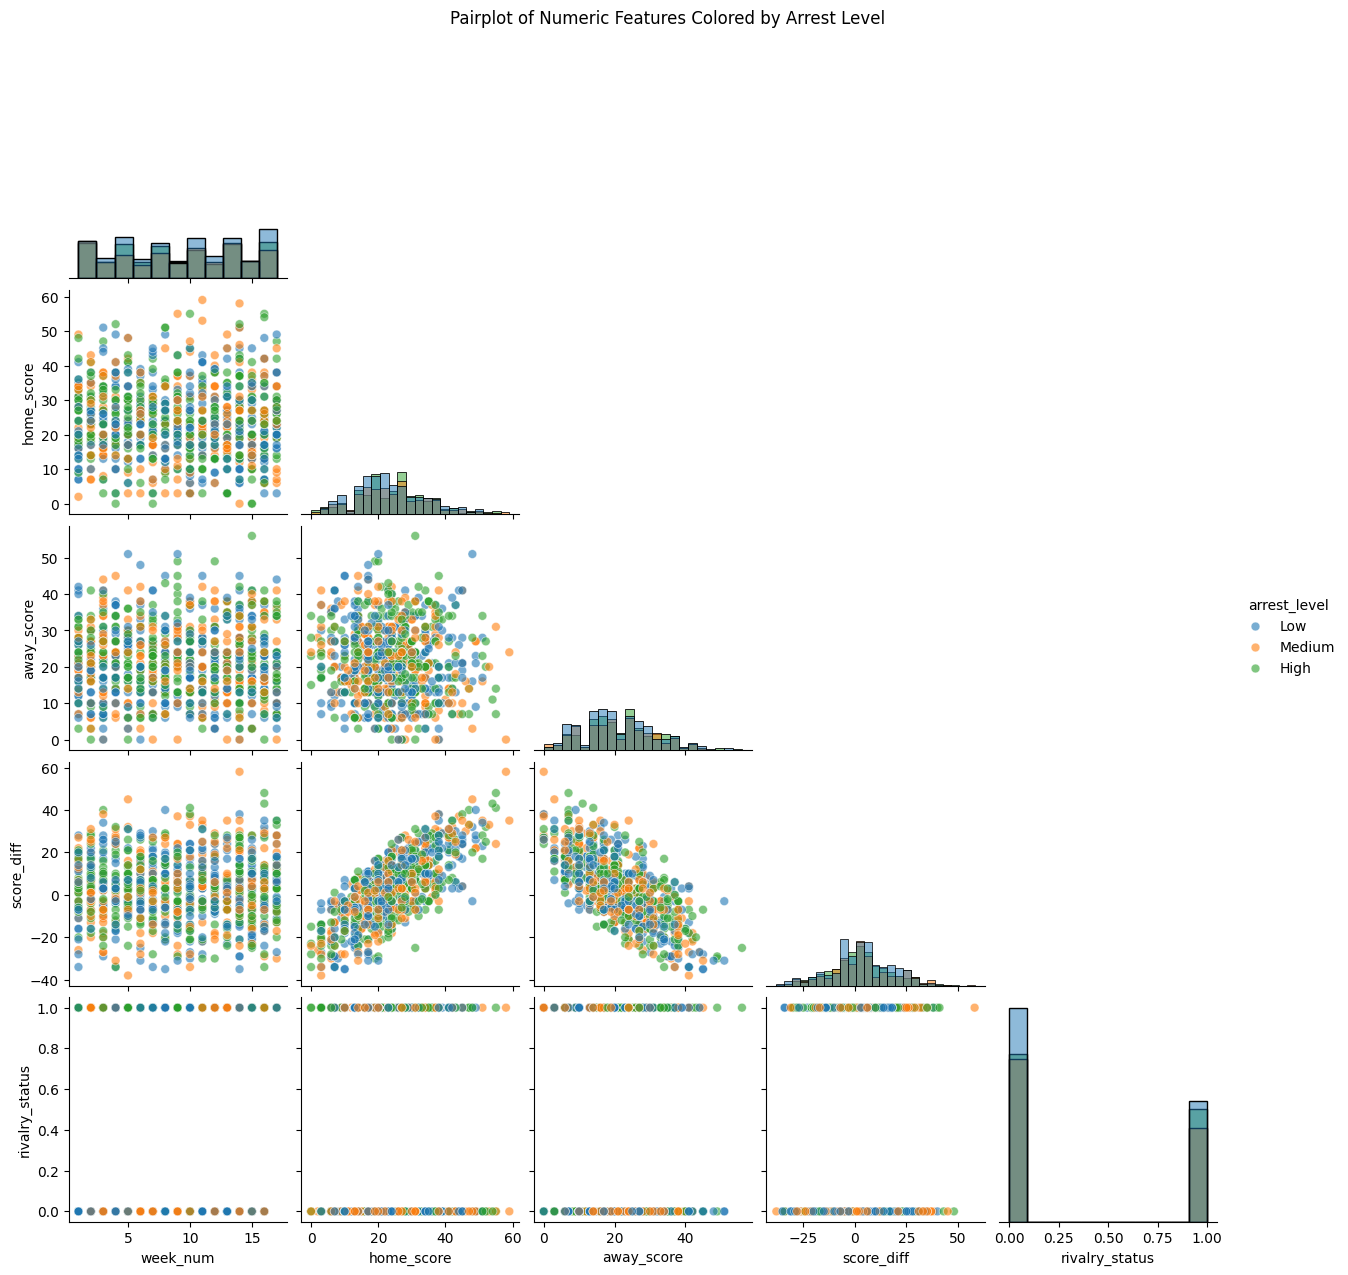

In [34]:
#pairplot
numeric_features = ['week_num','home_score','away_score','score_diff','rivalry_status']

sns.pairplot(df[numeric_features + ['arrest_level']],hue='arrest_level',diag_kind='hist',corner=True,plot_kws={'alpha':0.6, 's':40})
plt.suptitle('Pairplot of Numeric Features Colored by Arrest Level', y=1.02)
plt.show()

### Arrests by Rivalry (Division) Games

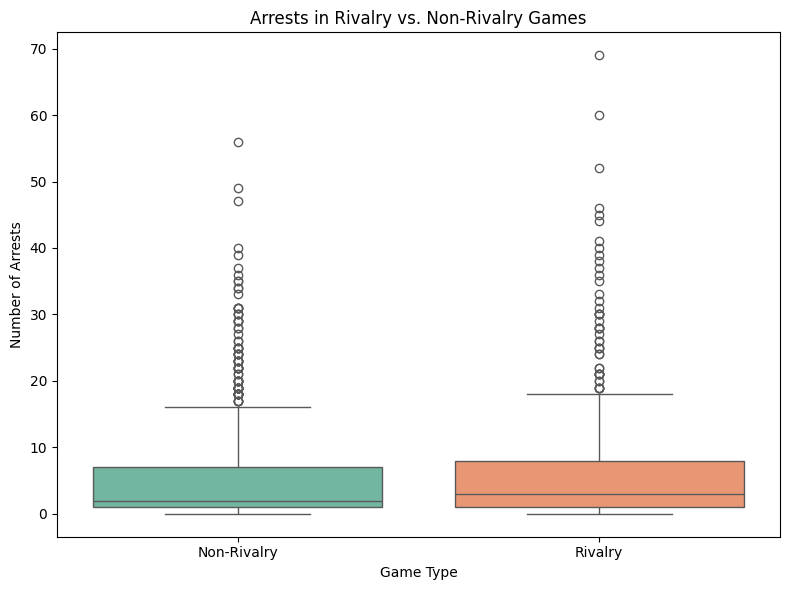

In [35]:
rivalry_df = df.dropna(subset=['arrests', 'division_game']).copy()

#turn 0 and 1 into readable labels
rivalry_df['rivalry_label'] = rivalry_df['rivalry_status'].map({0: 'Non-Rivalry',1: 'Rivalry'})

plt.figure(figsize=(8, 6))
sns.boxplot(data=rivalry_df, x='rivalry_label',y='arrests', palette='Set2')
plt.title('Arrests in Rivalry vs. Non-Rivalry Games')
plt.xlabel('Game Type')
plt.ylabel('Number of Arrests')
plt.tight_layout()
plt.show()

### Arrests by Week Number

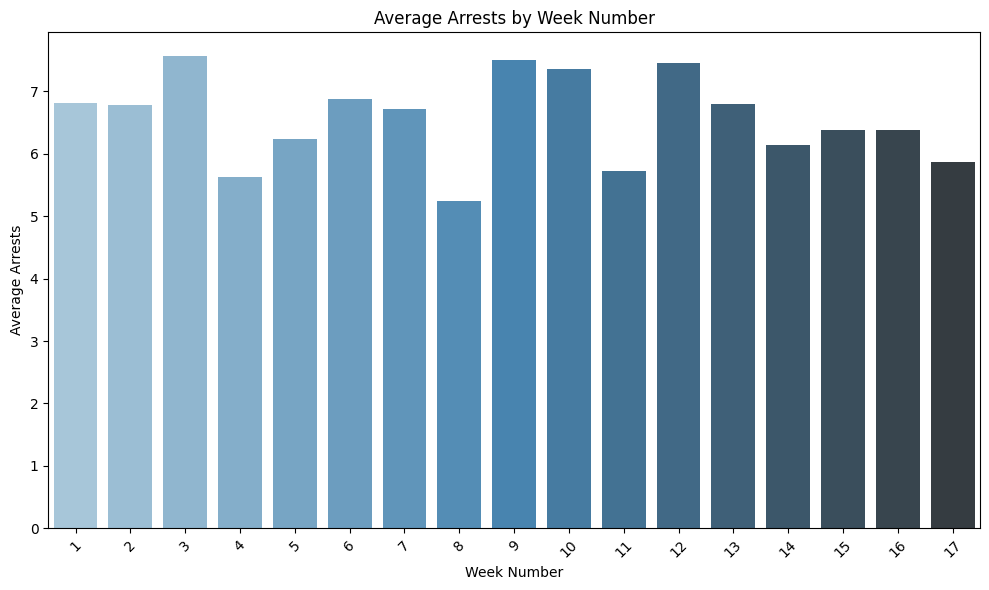

In [36]:
plt.figure(figsize=(10, 6))

#average arrests per week
weekly_avg = df.groupby("week_num")["arrests"].mean().reset_index()

sns.barplot(data=weekly_avg, x="week_num", y="arrests", palette="Blues_d")
plt.title("Average Arrests by Week Number")
plt.xlabel("Week Number")
plt.ylabel("Average Arrests")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Arrests vs Score Difference and Game Context

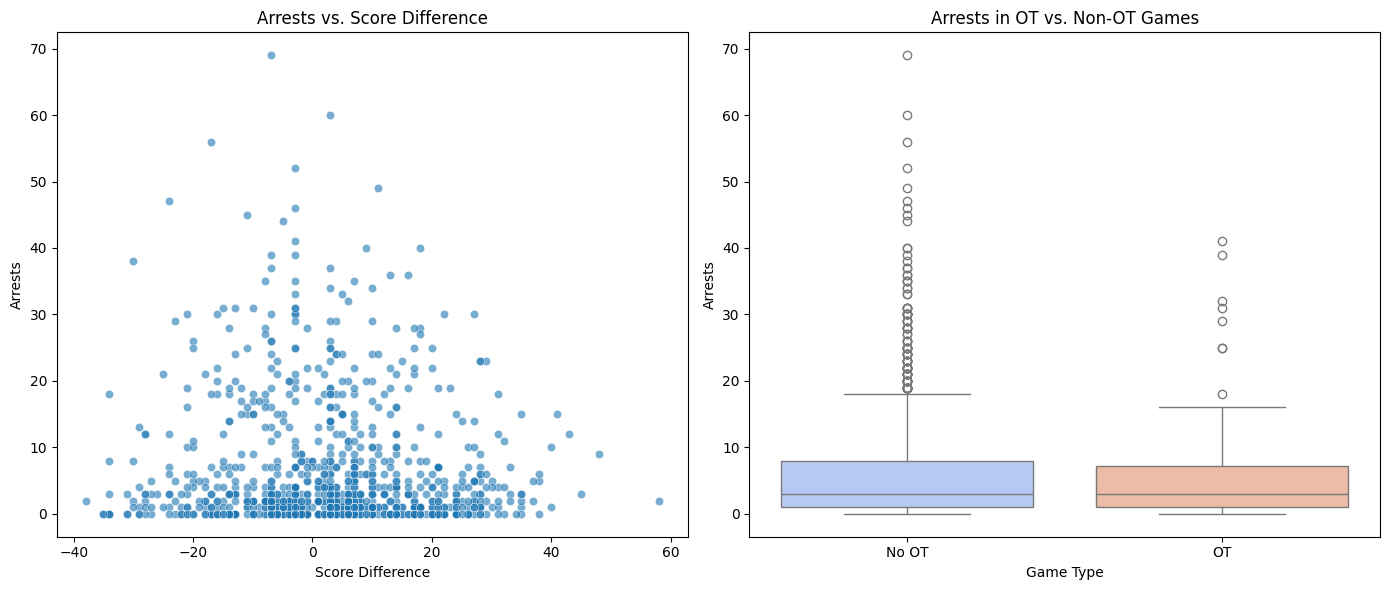

In [37]:
#set up the plot grid
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

#chart 1: Score difference vs arrests (scatter plot)
sns.scatterplot(data=df, x='score_diff', y='arrests', alpha=0.6, ax=axes[0])
axes[0].set_title("Arrests vs. Score Difference")
axes[0].set_xlabel("Score Difference")
axes[0].set_ylabel("Arrests")

#chart 2: OT vs non-OT boxplot
sns.boxplot(data=df, x='OT', y='arrests', palette='coolwarm', ax=axes[1])
axes[1].set_title("Arrests in OT vs. Non-OT Games")
axes[1].set_xlabel("Game Type")
axes[1].set_ylabel("Arrests")

plt.tight_layout()
plt.show()

### Arrests for Home Team vs Away Team Wins

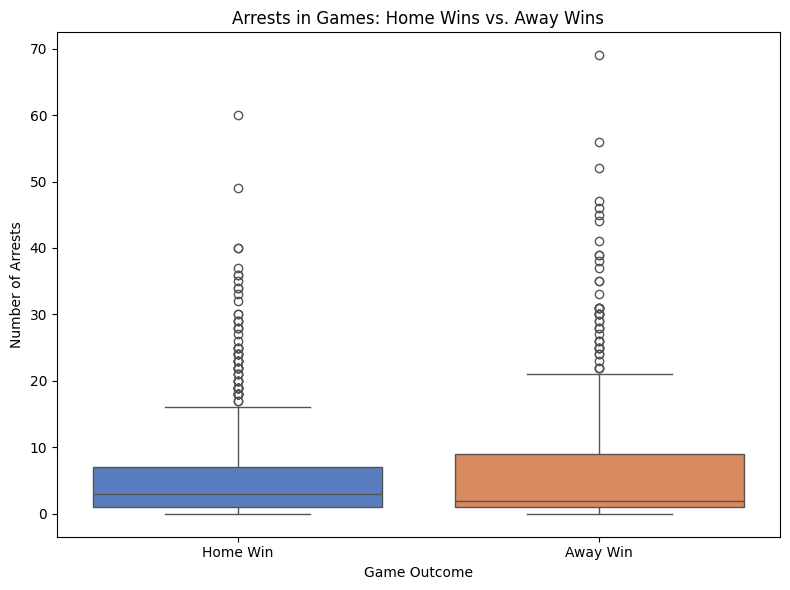

In [38]:
#boxplot comparing arrests for home vs away wins
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='game_outcome', y='arrests', palette='muted')
plt.title("Arrests in Games: Home Wins vs. Away Wins")
plt.xlabel("Game Outcome")
plt.ylabel("Number of Arrests")
plt.tight_layout()
plt.show()

### Average Arrests by Stadium

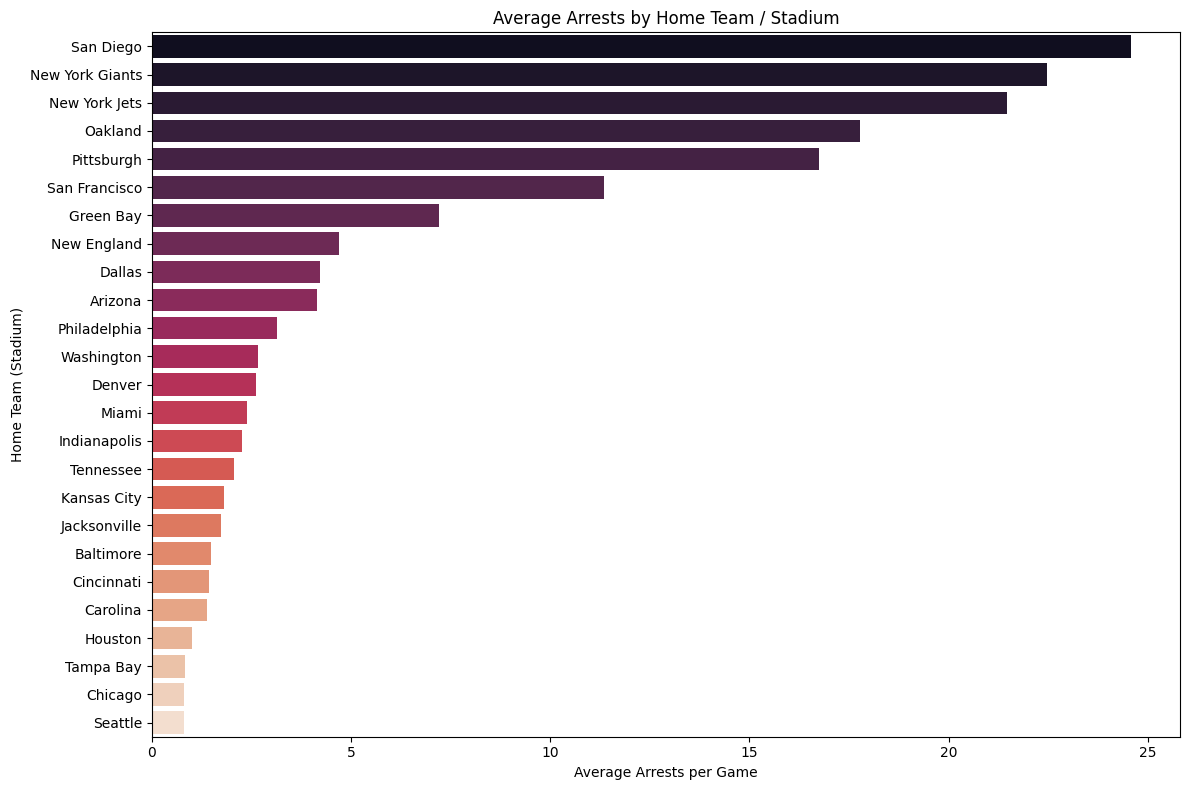

In [39]:
#average arrests by home team
team_avg = df.groupby("home_team")["arrests"].mean().reset_index().sort_values(by="arrests", ascending=False)

#plot average arrests per home team
plt.figure(figsize=(12, 8))
sns.barplot(data=team_avg, y="home_team", x="arrests", palette="rocket")
plt.title("Average Arrests by Home Team / Stadium")
plt.xlabel("Average Arrests per Game")
plt.ylabel("Home Team (Stadium)")
plt.tight_layout()
plt.show()

### Average Arrests by Team

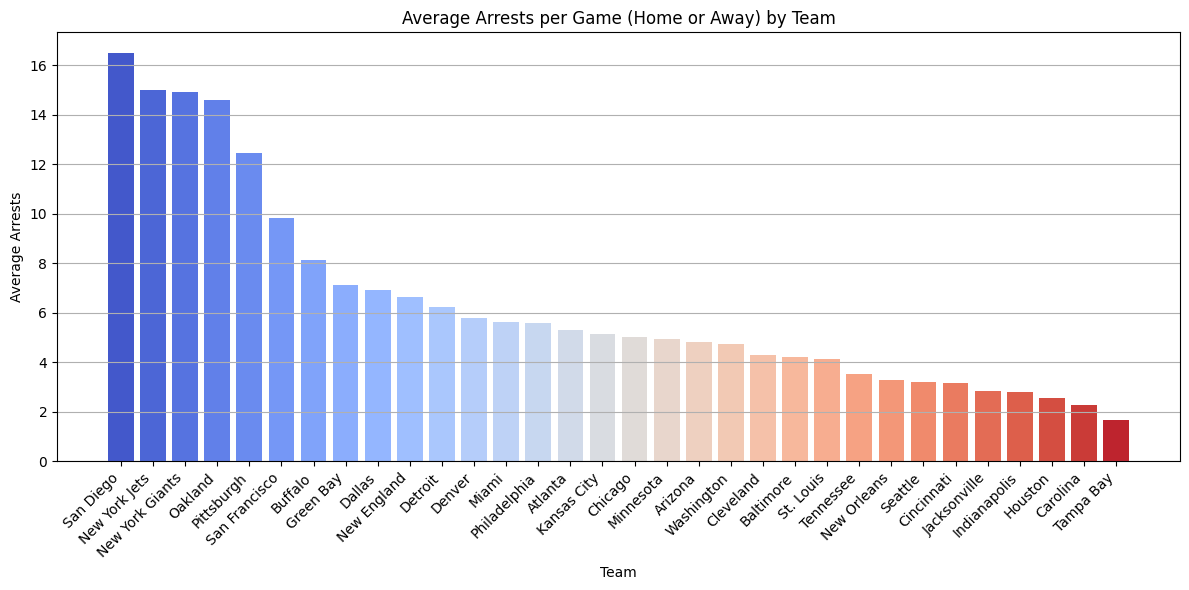

In [40]:
#melt team columns into one to aggregate arrests regardless of home/away
team_home = arrests_df[['home_team', 'arrests']].rename(columns={'home_team': 'team'})
team_away = arrests_df[['away_team', 'arrests']].rename(columns={'away_team': 'team'})

#Combine both to get all team appearances
team_all = pd.concat([team_home, team_away])

#group by team and calculate average arrests
team_avg_arrests = team_all.groupby('team')['arrests'].mean().sort_values(ascending=False).reset_index()

colors = sns.color_palette("coolwarm", len(team_avg_arrests))
sorted_colors = [color for _, color in sorted(zip(team_avg_arrests['arrests'], colors), reverse=True)]

plt.figure(figsize=(12, 6))
plt.bar(team_avg_arrests['team'], team_avg_arrests['arrests'], color=sorted_colors)
plt.title('Average Arrests per Game (Home or Away) by Team')
plt.xlabel('Team')
plt.ylabel('Average Arrests')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

## Modeling
Train classification models to predict arrest level using engineered game features.


In [41]:
#modeling section
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#one-hot encoding for models
categorical_cols = ['home_team','away_team','day_of_week','division_game','OT']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

#create and encode categorical target from arrests count
df['arrest_level']      = pd.qcut(df['arrests'], q=3, labels=['Low','Medium','High'])
df['arrest_level_code'] = LabelEncoder().fit_transform(df['arrest_level'])

#define features and target
drop_cols = ['arrests','OT_flag','gametime_local','game_outcome','arrest_level'] #game outcome redundant since score_diff already relays that info
X = df.drop(columns=drop_cols + ['arrest_level_code'])
y = df['arrest_level_code']

#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,stratify=y,random_state=42)

In [42]:
#Logistic Regression test
logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train, y_train)

y_log_pred  = logreg.predict(X_test)
y_log_proba = logreg.predict_proba(X_test)

print("\n=== Logistic Regression ===")
print("Accuracy:  ", accuracy_score(y_test, y_log_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_log_pred))
print("Classification Report:\n", classification_report(y_test, y_log_pred))


=== Logistic Regression ===
Accuracy:   0.654639175257732
Confusion Matrix:
 [[50  2 10]
 [ 4 55 16]
 [13 22 22]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.81      0.78        62
           1       0.70      0.73      0.71        75
           2       0.46      0.39      0.42        57

    accuracy                           0.65       194
   macro avg       0.63      0.64      0.64       194
weighted avg       0.64      0.65      0.65       194



In [43]:
#RandomForest test
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_rf_pred  = rf.predict(X_test)
y_rf_proba = rf.predict_proba(X_test)

print("\n=== Random Forest ===")
print("Accuracy:  ", accuracy_score(y_test, y_rf_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_rf_pred))
print("Classification Report:\n", classification_report(y_test, y_rf_pred))


=== Random Forest ===
Accuracy:   0.654639175257732
Confusion Matrix:
 [[51  4  7]
 [ 5 58 12]
 [ 8 31 18]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81        62
           1       0.62      0.77      0.69        75
           2       0.49      0.32      0.38        57

    accuracy                           0.65       194
   macro avg       0.64      0.64      0.63       194
weighted avg       0.64      0.65      0.64       194



In [44]:
#XGBoost no tuning test
vanilla_xgb = XGBClassifier(objective='multi:softprob',use_label_encoder=False,eval_metric='mlogloss',random_state=42)
vanilla_xgb.fit(X_train, y_train)

y_v_pred  = vanilla_xgb.predict(X_test)
y_v_proba = vanilla_xgb.predict_proba(X_test)

print("=== Vanilla XGBoost ===")
print("Accuracy:", accuracy_score(y_test, y_v_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_v_pred))
print("Classification Report:\n", classification_report(y_test, y_v_pred))

=== Vanilla XGBoost ===
Accuracy: 0.634020618556701
Confusion Matrix:
 [[51  5  6]
 [ 7 50 18]
 [ 6 29 22]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81        62
           1       0.60      0.67      0.63        75
           2       0.48      0.39      0.43        57

    accuracy                           0.63       194
   macro avg       0.62      0.63      0.62       194
weighted avg       0.63      0.63      0.63       194



## Cross-Validation
Compare baseline models using 5-fold stratified cross-validation to estimate generalization performance.

In [45]:
# cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models_cv = {
    "LogisticRegression": make_pipeline(StandardScaler(), LogisticRegression(solver="saga", max_iter=5000)),
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(objective="multi:softprob", eval_metric="mlogloss", random_state=42),
}

print("=== 5-Fold CV (Accuracy ± Std) ===")
for name, model in models_cv.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy")
    print(f"{name}: {scores.mean():.3f} ± {scores.std():.3f}")

=== 5-Fold CV (Accuracy ± Std) ===
LogisticRegression: 0.606 ± 0.022
RandomForest: 0.607 ± 0.027
XGBoost: 0.575 ± 0.028


## Hyperparameter Tuning (GridSearchCV)
Tune XGBoost hyperparameters using GridSearchCV to improve performance, especially on the high-arrest class.

In [46]:
#hyperparameter tuning + grid search
param_grid = {'n_estimators': [100, 200, 300],'max_depth':[3, 5, 7],'learning_rate':[0.01, 0.1],'subsample':[0.8, 1.0],'colsample_bytree': [0.8, 1.0]}

grid = GridSearchCV(estimator=XGBClassifier(objective='multi:softprob',use_label_encoder=False,eval_metric='mlogloss',random_state=42),param_grid=param_grid,cv=cv,scoring='accuracy',n_jobs=-1,verbose=1)
grid.fit(X_train, y_train)

best_xgb = grid.best_estimator_
print("Best XGBoost params:", grid.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best XGBoost params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


## Final Model Evaluation
Evaluate the tuned XGBoost model on the held-out test set and summarize overall performance.

In [47]:
#tuned XGBoost test
y_t_pred  = best_xgb.predict(X_test)
y_t_proba = best_xgb.predict_proba(X_test)

print("=== Tuned XGBoost ===")
print("Accuracy:  ", accuracy_score(y_test, y_t_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_t_pred))
print("Classification Report:\n", classification_report(y_test, y_t_pred))

=== Tuned XGBoost ===
Accuracy:   0.6752577319587629
Confusion Matrix:
 [[49  4  9]
 [ 5 60 10]
 [ 6 29 22]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.79      0.80        62
           1       0.65      0.80      0.71        75
           2       0.54      0.39      0.45        57

    accuracy                           0.68       194
   macro avg       0.67      0.66      0.66       194
weighted avg       0.67      0.68      0.66       194



## Ensemble (Optional)
Test a simple ensemble approach to compare stability versus the best single model.

In [48]:
#ensemble
ensemble = VotingClassifier(estimators=[("logreg", logreg), ("rf", rf), ("xgb", best_xgb)],voting='soft',n_jobs=-1)
ensemble.fit(X_train, y_train)

y_e_pred  = ensemble.predict(X_test)
y_e_proba = ensemble.predict_proba(X_test)

print("=== Ensemble (RF + Tuned XGB) ===")
print("Accuracy:  ", accuracy_score(y_test, y_e_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_e_pred))
print("Classification Report:\n", classification_report(y_test, y_e_pred))

=== Ensemble (RF + Tuned XGB) ===
Accuracy:   0.6752577319587629
Confusion Matrix:
 [[49  2 11]
 [ 4 61 10]
 [ 8 28 21]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.79      0.80        62
           1       0.67      0.81      0.73        75
           2       0.50      0.37      0.42        57

    accuracy                           0.68       194
   macro avg       0.66      0.66      0.65       194
weighted avg       0.66      0.68      0.66       194

